<a href="https://colab.research.google.com/github/HelenLit/bbc-news_nlp/blob/main/bbc_news.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Exploring the BBC News archive

In this project I am working with a variation of the [BBC News Classification Dataset](https://www.kaggle.com/c/learn-ai-bbc/overview), which contains 2225 examples of news articles with their respective categories (labels).

In [1]:
!wget https://raw.githubusercontent.com/HelenLit/bbc-news_nlp/main/bbc-text.csv
!wget https://raw.githubusercontent.com/HelenLit/bbc-news_nlp/main/bbc-text-minimal.csv

--2023-09-05 19:13:00--  https://raw.githubusercontent.com/HelenLit/bbc-news_nlp/main/bbc-text.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5057493 (4.8M) [text/plain]
Saving to: ‘bbc-text.csv’

bbc-text.csv        100%[===================>]   4.82M  --.-KB/s    in 0.04s   

2023-09-05 19:13:00 (112 MB/s) - ‘bbc-text.csv’ saved [5057493/5057493]

--2023-09-05 19:13:00--  https://raw.githubusercontent.com/HelenLit/bbc-news_nlp/main/bbc-text-minimal.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11337 (11K) [text/plain]


In [36]:
import io
import csv
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

Looking at the structure of the csv that contains the data:

In [7]:
with open("./bbc-text.csv", 'r') as csvfile:
    print(f"First line (header) looks like this:\n\n{csvfile.readline()}")
    print(f"Each data point looks like this:\n\n{csvfile.readline()}")

First line (header) looks like this:

category,text

Each data point looks like this:

tech,tv future in the hands of viewers with home theatre systems  plasma high-definition tvs  and digital video recorders moving into the living room  the way people watch tv will be radically different in five years  time.  that is according to an expert panel which gathered at the annual consumer electronics show in las vegas to discuss how these new technologies will impact one of our favourite pastimes. with the us leading the trend  programmes and other content will be delivered to viewers via home networks  through cable  satellite  telecoms companies  and broadband service providers to front rooms and portable devices.  one of the most talked-about technologies of ces has been digital and personal video recorders (dvr and pvr). these set-top boxes  like the us s tivo and the uk s sky+ system  allow people to record  store  play  pause and forward wind tv programmes when they want.  essentially

## Defining useful global variables

- `NUM_WORDS`: The maximum number of words to keep, based on word frequency. Defaults to 1000.


- `EMBEDDING_DIM`: Dimension of the dense embedding, will be used in the embedding layer of the model. Defaults to 16.


- `MAXLEN`: Maximum length of all sequences. Defaults to 120.


- `PADDING`: Padding strategy (pad either before or after each sequence.). Defaults to 'post'.


- `OOV_TOKEN`: Token to replace out-of-vocabulary words during text_to_sequence calls. Defaults to "\<OOV>".

    
- `TRAINING_SPLIT`: Proportion of data used for training. Defaults to 0.8

In [3]:
NUM_WORDS = 1000
EMBEDDING_DIM = 16
MAXLEN = 120
PADDING = 'post'
OOV_TOKEN = "<OOV>"
TRAINING_SPLIT = .8

Each data point is composed of the category of the news article followed by a comma and then the actual text of the article.

## Removing Stopwords

One important step when working with text data is to remove the **stopwords** from it. These are the most common words in the language and they rarely provide useful information for the classification process.

`remove_stopwords` function receives a string and returns another string that excludes all of the stopwords provided.

In [8]:
def remove_stopwords(sentence):
    """
    Removes a list of stopwords

    Args:
        sentence (string): sentence to remove the stopwords from

    Returns:
        sentence (string): lowercase sentence without the stopwords
    """
    # Set of stopwords for faster lookup
    stopwords = set(["a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him", "himself", "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "it", "it's", "its", "itself", "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", "so", "some", "such", "than", "that", "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we", "we'd", "we'll", "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's", "which", "while", "who", "who's", "whom", "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves" ])

    # Sentencing converted to lowercase-only
    sentence = sentence.lower()
    words = sentence.split()
    # Removing stopwords using list comprehension
    words_without_stopwords = [word for word in words if word not in stopwords]

    # Joining the words back into a sentence
    sentence = ' '.join(words_without_stopwords)
    return sentence

## Reading the raw data

`parse_data_from_file` function reads the data from the csv file

In [9]:
def parse_data_from_file(filename):
    """
    Extracts sentences and labels from a CSV file

    Args:
        filename (string): path to the CSV file

    Returns:
        sentences, labels (list of string, list of string): tuple containing lists of sentences and labels
    """
    sentences = []
    labels = []
    with open(filename, 'r') as csvfile:
        reader = csv.reader(csvfile, delimiter=',')
        next(reader)
        for row in reader:
            labels.append(row[0])
            sentence = remove_stopwords(row[1])
            sentences.append(sentence)
    return sentences, labels

In [12]:
# Testing parse_data_from_file function

# With original dataset
sentences, labels = parse_data_from_file("./bbc-text.csv")

print("ORIGINAL DATASET:\n")
print(f"There are {len(sentences)} sentences in the dataset.\n")
print(f"First sentence has {len(sentences[0].split())} words (after removing stopwords).\n")
print(f"There are {len(labels)} labels in the dataset.\n")
print(f"The first 5 labels are {labels[:5]}\n\n")

# With a miniature version of the dataset that contains only first 5 rows
mini_sentences, mini_labels = parse_data_from_file("./bbc-text-minimal.csv")

print("MINIATURE DATASET:\n")
print(f"There are {len(mini_sentences)} sentences in the miniature dataset.\n")
print(f"First sentence has {len(mini_sentences[0].split())} words (after removing stopwords).\n")
print(f"There are {len(mini_labels)} labels in the miniature dataset.\n")
print(f"The first 5 labels are {mini_labels[:5]}")

ORIGINAL DATASET:

There are 2225 sentences in the dataset.

First sentence has 436 words (after removing stopwords).

There are 2225 labels in the dataset.

The first 5 labels are ['tech', 'business', 'sport', 'sport', 'entertainment']


MINIATURE DATASET:

There are 5 sentences in the miniature dataset.

First sentence has 436 words (after removing stopwords).

There are 5 labels in the miniature dataset.

The first 5 labels are ['tech', 'business', 'sport', 'sport', 'entertainment']


## Training - Validation Split

Given the training split size, the `train_val_split()` function will split the full lists of sentences and labels into training and validation sentences and labels.

In [15]:
def train_val_split(sentences, labels, training_split):
    """
    Splits the dataset into training and validation sets

    Args:
        sentences (list of string): lower-cased sentences without stopwords
        labels (list of string): list of labels
        training split (float): proportion of the dataset to convert to include in the train set

    Returns:
        train_sentences, validation_sentences, train_labels, validation_labels - lists containing the data splits
    """

    # Compute the number of sentences that will be used for training (should be an integer)
    train_size = int(len(sentences)*training_split)

    # Split the sentences and labels into train/validation splits
    train_sentences = sentences[:train_size]
    train_labels = labels[:train_size]

    validation_sentences = sentences[train_size:]
    validation_labels = labels[train_size:]

    return train_sentences, validation_sentences, train_labels, validation_labels

In [16]:
# Testing train_val_split function
train_sentences, val_sentences, train_labels, val_labels = train_val_split(sentences, labels, TRAINING_SPLIT)

print(f"There are {len(train_sentences)} sentences for training.\n")
print(f"There are {len(train_labels)} labels for training.\n")
print(f"There are {len(val_sentences)} sentences for validation.\n")
print(f"There are {len(val_labels)} labels for validation.")

There are 1780 sentences for training.

There are 1780 labels for training.

There are 445 sentences for validation.

There are 445 labels for validation.


## Using the Tokenizer

`fit_tokenizer` function tokenizes the sentences of the dataset.  

This function receives the list of sentences as input and return a [Tokenizer](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer) that has been fitted to those sentences.

In [17]:
def fit_tokenizer(train_sentences, num_words, oov_token):
    """
    Instantiates the Tokenizer class

    Args:
        train_sentences (list of string): lower-cased sentences without stopwords to be used for training
        num_words (int) - number of words to keep when tokenizing
        oov_token (string) - symbol for the out-of-vocabulary token

    Returns:
        tokenizer (object): an instance of the Tokenizer class containing the word-index dictionary
    """

    # Instantiating the Tokenizer class by passing in the oov_token argument
    tokenizer = Tokenizer(num_words = num_words, oov_token = oov_token)

    # Fitting on the sentences
    tokenizer.fit_on_texts(train_sentences)

    return tokenizer

In [19]:
tokenizer = fit_tokenizer(train_sentences, NUM_WORDS, OOV_TOKEN)
word_index = tokenizer.word_index

print(f"Vocabulary contains {len(word_index)} words\n")
print("<OOV> token included in vocabulary" if "<OOV>" in word_index else "<OOV> token NOT included in vocabulary")

Vocabulary contains 27285 words

<OOV> token included in vocabulary


In [20]:
def seq_and_pad(sentences, tokenizer, padding, maxlen):
    """
    Generates an array of token sequences and pads them to the same length

    Args:
        sentences (list of string): list of sentences to tokenize and pad
        tokenizer (object): Tokenizer instance containing the word-index dictionary
        padding (string): type of padding to use
        maxlen (int): maximum length of the token sequence

    Returns:
        padded_sequences (array of int): tokenized sentences padded to the same length
    """
    # Converting sentences to sequences
    sequences = tokenizer.texts_to_sequences(sentences)

    # Padding the sequences using the post padding strategy
    padded_sequences = pad_sequences(sequences, maxlen=maxlen, padding=padding)

    return padded_sequences

In [21]:
# Testing seq_and_pad function
train_padded_seq = seq_and_pad(train_sentences, tokenizer, PADDING, MAXLEN)
val_padded_seq = seq_and_pad(val_sentences, tokenizer, PADDING, MAXLEN)

print(f"Padded training sequences have shape: {train_padded_seq.shape}\n")
print(f"Padded validation sequences have shape: {val_padded_seq.shape}")

Padded training sequences have shape: (1780, 120)

Padded validation sequences have shape: (445, 120)


In [23]:
def tokenize_labels(all_labels, split_labels):
    """
    Tokenizes the labels

    Args:
        all_labels (list of string): labels to generate the word-index from
        split_labels (list of string): labels to tokenize

    Returns:
        label_seq_np (array of int): tokenized labels
    """

    # Instantiating the Tokenizer (no additional arguments needed)
    label_tokenizer = Tokenizer()

    # Fitting the tokenizer on all the labels
    label_tokenizer.fit_on_texts(all_labels)

    # Converting labels to sequences
    label_seq = label_tokenizer.texts_to_sequences(split_labels)

    # Converting sequences to a numpy array
    label_seq_np = np.array(label_seq) - 1

    return label_seq_np

In [25]:
train_label_seq = tokenize_labels(labels, train_labels)
val_label_seq = tokenize_labels(labels, val_labels)

print(f"First 5 labels of the training set should look like this:\n{train_label_seq[:5]}\n")
print(f"First 5 labels of the validation set should look like this:\n{val_label_seq[:5]}\n")
print(f"Tokenized labels of the training set have shape: {train_label_seq.shape}\n")
print(f"Tokenized labels of the validation set have shape: {val_label_seq.shape}\n")

First 5 labels of the training set should look like this:
[[3]
 [1]
 [0]
 [0]
 [4]]

First 5 labels of the validation set should look like this:
[[4]
 [3]
 [2]
 [0]
 [0]]

Tokenized labels of the training set have shape: (1780, 1)

Tokenized labels of the validation set have shape: (445, 1)



## Selecting the model for text classification

Now that the data is ready to be fed a Neural Network it is time to define the model that will classify each text as being part of a certain category.

[GlobalAveragePooling1D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalAveragePooling1D)

In [26]:
def create_model(num_words, embedding_dim, maxlen):
    """
    Creates a text classifier model

    Args:
        num_words (int): size of the vocabulary for the Embedding layer input
        embedding_dim (int): dimensionality of the Embedding layer output
        maxlen (int): length of the input sequences

    Returns:
        model (tf.keras Model): the text classifier model
    """

    tf.random.set_seed(123)

    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(num_words, embedding_dim, input_length = maxlen),
        tf.keras.layers.GlobalAveragePooling1D(),
        tf.keras.layers.Dense(25, activation='relu'),
        tf.keras.layers.Dense(5, activation='softmax')
    ])

    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    return model

In [29]:
model = create_model(NUM_WORDS, EMBEDDING_DIM, MAXLEN)

history = model.fit(train_padded_seq, train_label_seq, epochs=30, validation_data=(val_padded_seq, val_label_seq))

Epoch 1/30
56/56 [==============================] - 1s 6ms/step - loss: 1.5982 - accuracy: 0.2253 - val_loss: 1.5816 - val_accuracy: 0.2831
Epoch 2/30
56/56 [==============================] - 0s 3ms/step - loss: 1.5528 - accuracy: 0.3770 - val_loss: 1.5131 - val_accuracy: 0.3730
Epoch 3/30
56/56 [==============================] - 0s 3ms/step - loss: 1.4394 - accuracy: 0.4871 - val_loss: 1.3607 - val_accuracy: 0.5820
Epoch 4/30
56/56 [==============================] - 0s 3ms/step - loss: 1.2369 - accuracy: 0.7073 - val_loss: 1.1374 - val_accuracy: 0.7888
Epoch 5/30
56/56 [==============================] - 0s 3ms/step - loss: 0.9959 - accuracy: 0.8185 - val_loss: 0.9168 - val_accuracy: 0.8247
Epoch 6/30
56/56 [==============================] - 0s 4ms/step - loss: 0.7861 - accuracy: 0.8685 - val_loss: 0.7413 - val_accuracy: 0.8607
Epoch 7/30
56/56 [==============================] - 0s 3ms/step - loss: 0.6280 - accuracy: 0.8938 - val_loss: 0.6189 - val_accuracy: 0.8764
Epoch 8/30
56/56 [==

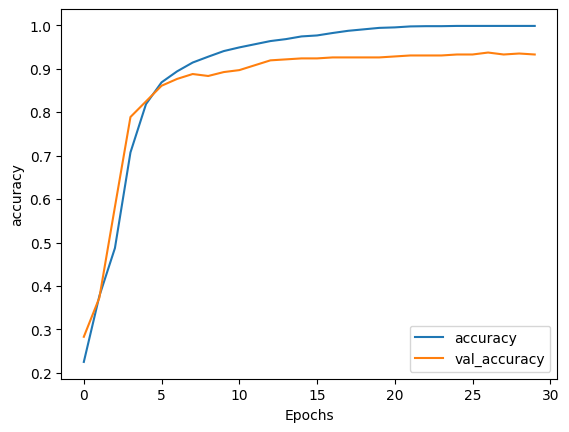

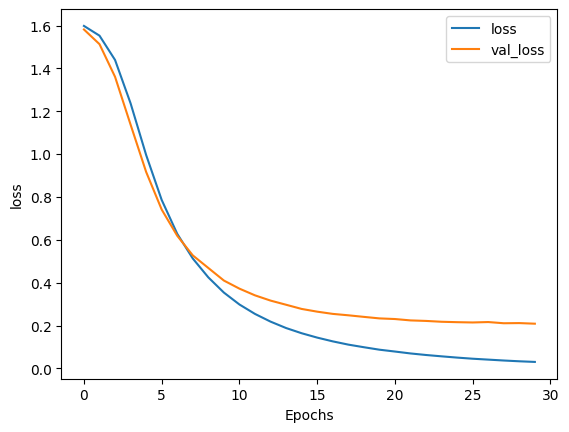

In [32]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history[f'val_{metric}'])
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, f'val_{metric}'])
    plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

##Visualizing 3D Vectors

We can visualize the vectors associated with each word in the training set in a 3D space with [Tensorflow's Embedding Projector](https://projector.tensorflow.org/).

In [34]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

# Saving the embedding layer
e = model.layers[0]

# Saving the weights of the embedding layer
weights = e.get_weights()[0]
print(f"Weights of embedding layer have shape: {weights.shape}")

Weights of embedding layer have shape: (1000, 16)


In [38]:
# Generating files for embedding visualization
out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, NUM_WORDS):
    word = reverse_word_index[word_num]
    embeddings = weights[word_num]
    out_m.write(word + "\n")
    out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()